In [2]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
A0 = 0.05984281113 
CLA = 4.752798721
CLA_STALL = -3.85 
CDA = 0.6417112299
CDA_STALL = -0.9233984055
ALPHA_STALL = 0.3391428111
WINGAREA = 0.6
AIR_DENSITY = 1.2041
MASS = 1.5
G = 9.81

In [4]:
def calc_cl(angle_of_attack):
    clift = CLA * (angle_of_attack - A0)
    return clift

def calc_v_stall(clMax):
    vStall = np.sqrt((2 * MASS * G) / (AIR_DENSITY * WINGAREA * clMax))
    return vStall

In [5]:
angleList = np.arange(0, ALPHA_STALL, 0.01 * np.pi/180)
coefficient_lift_list = [calc_cl(angle) for angle in angleList]
clMax = max(coefficient_lift_list)
clMaxWeights = [.9375, .8750, .8125, .750]
vStall = calc_v_stall(clMax)
angleListDegrees = np.rad2deg(angleList)
structural_limit = np.sqrt((2 * 5 * MASS * G) / (clMax * WINGAREA * AIR_DENSITY))

print(clMax)

1.327336258892164


In [6]:
def filter_data(dataframe, start_time, end_time):
    filtered_df = dataframe[(dataframe['time'] >= start_time) & (dataframe['time'] <= end_time)]
    return filtered_df

In [7]:
def check_bounds(predicted_velocity, predicted_load_factor, velocities_lists, calc_load_factor_lists):
    num_lines_crossed = 0
    for calc_load_factor_list in calc_load_factor_lists:
        closest_index = np.argmin(np.abs(np.array(velocities_lists) - predicted_velocity))
        closest_load_factor = calc_load_factor_list[closest_index]
        if predicted_load_factor > closest_load_factor:
            num_lines_crossed += 1
    return num_lines_crossed

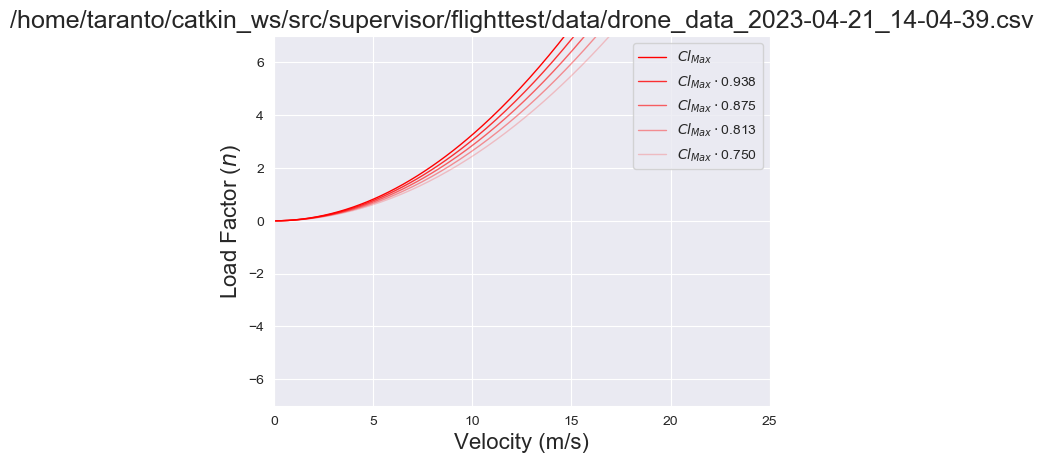

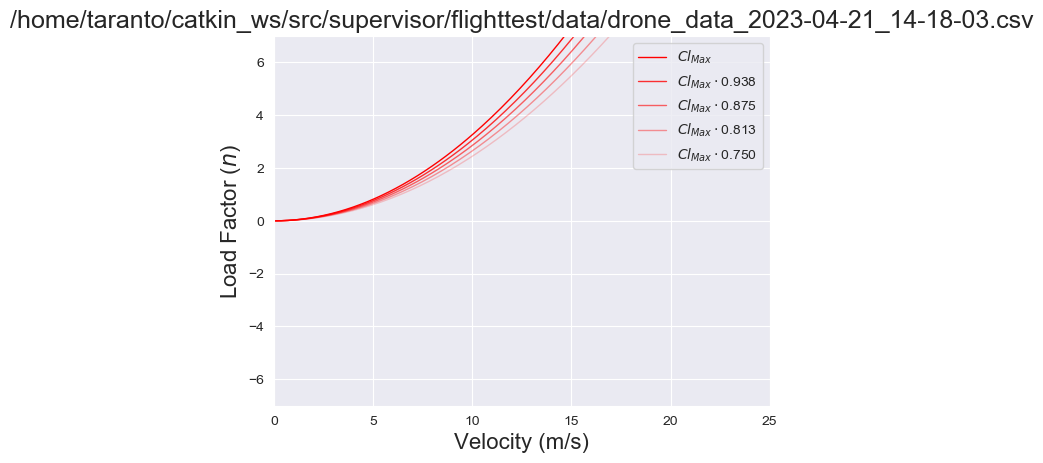

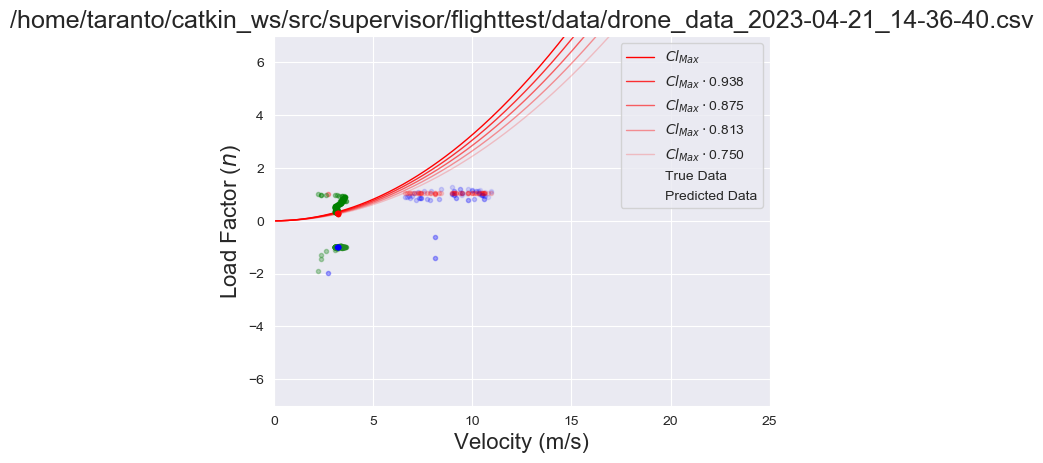

In [10]:
filenames = ["/home/taranto/catkin_ws/src/supervisor/flighttest/data/drone_data_2023-04-21_14-04-39.csv", "/home/taranto/catkin_ws/src/supervisor/flighttest/data/drone_data_2023-04-21_14-18-03.csv", "/home/taranto/catkin_ws/src/supervisor/flighttest/data/drone_data_2023-04-21_14-36-40.csv"] 
plotNames = ['1','2','3']
time_data = []
true_v = []
true_n = []
predict_v = []
predict_n = []
bound = []
bounds = []

START = 550
END = 600

sns.set_style('darkgrid')
font = "times new roman"
fontsizeT = 16
fontsizeL = 14

velocities = np.linspace(0, 30, 250)
calc_load_factor_lists = []
calc_load_factor_list = []
bounds = []

line_styles = ['-', '-', '-', '-', '-']
line_labels = ['$Cl_{Max}$', '$Cl_{Max}\cdot$0.938', '$Cl_{Max}\cdot$0.875', '$Cl_{Max}\cdot$0.813', '$Cl_{Max}\cdot$0.750']
line_colors = ['red', 'red', 'red', 'red', 'red']
line_opac = [1, 0.8, 0.6, 0.4, 0.2]


for v in velocities:
    dynamic_pressure = 0.5 * AIR_DENSITY * v ** 2
    lift = clMax * WINGAREA * dynamic_pressure
    load_factor = lift / (MASS * G)
    calc_load_factor_list.append(load_factor)
calc_load_factor_lists.append(calc_load_factor_list)

for weight in clMaxWeights:
    calc_load_factor_list = []
    for v in velocities:
        dynamic_pressure = 0.5 * AIR_DENSITY * v ** 2
        lift = clMax * weight * WINGAREA * dynamic_pressure
        load_factor = lift / (MASS * G)
        calc_load_factor_list.append(load_factor)
    calc_load_factor_lists.append(calc_load_factor_list)

def plot_static_data(ax):
    for load_factor, line_style, label, line_color, opacity in zip(calc_load_factor_lists, line_styles, line_labels, line_colors, line_opac):
        ax.plot(velocities, load_factor, color=line_color, linestyle=line_style, label=label, alpha=opacity, linewidth=1)

for i, file in enumerate(filenames):
    fig, ax = plt.subplots()
    plot_static_data(ax)

    # df = pd.read_csv(file)
    # time filter data to only include data between time START and END
    raw_df = pd.read_csv(file)
    df = filter_data(raw_df, START, END)

    time_data = df['time'].tolist()
    true_v = df['true_velocity'].tolist()
    true_n = df['n_true'].tolist()
    predict_v = df['predicted_velocity'].tolist()
    predict_n = df['predicted_n'].tolist()
    bound = df['bounds_crossed'].tolist()
    for i in range(len(time_data)):
        # Calculate alpha value based on time
        alpha_val = (time_data[i] - time_data[0]) / (time_data[-1] - time_data[0])

        true_color = 'blue' if bound[i] <= 4 else 'forestgreen'
        predict_color = 'red' if bound[i] <= 4 else 'green'
        ax.plot(true_v[i], true_n[i], 'o', alpha=alpha_val, markersize=3, color=true_color, label='True Data' if i == 0 else None)
        ax.plot(predict_v[i], predict_n[i], 'o', alpha=alpha_val, markersize=3, color=predict_color, label='Predicted Data' if i == 0 else None)

    ax.legend()
    ax.set_ylim([-7, 7])
    ax.set_xlim(left=0, right=25)
    ax.set_xlabel('Velocity (m/s)', fontsize=16)
    ax.set_ylabel('Load Factor ($n$)', fontsize=16)
    ax.set_title(file, fontsize=18)
    slicefile = file[:-7]
    # fig.savefig(f"svgs/{slicefile}.svg")



In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

df2 = pd.read_csv("/home/taranto/catkin_ws/src/supervisor/flighttest/data/fixedbag-DataLoggerN.csv")

# Remove the key_event and key_event_time columns
df2.drop(columns=['key_event', 'key_event_time'], inplace=True)

num_lines_crossed = []
for index, row in df2.iterrows():
    predicted_velocity = row['predicted_velocity']
    predicted_load_factor = row['predicted_n']
    num_lines_crossed.append(check_bounds(predicted_velocity, predicted_load_factor, velocities, calc_load_factor_lists))
df2['bounds_crossed'] = num_lines_crossed

# Save the updated DataFrame back to the same file
df2.to_csv("/home/taranto/catkin_ws/src/supervisor/flighttest/data/fixedbag-DataLoggerN.csv", index=False)
print(num_lines_crossed)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


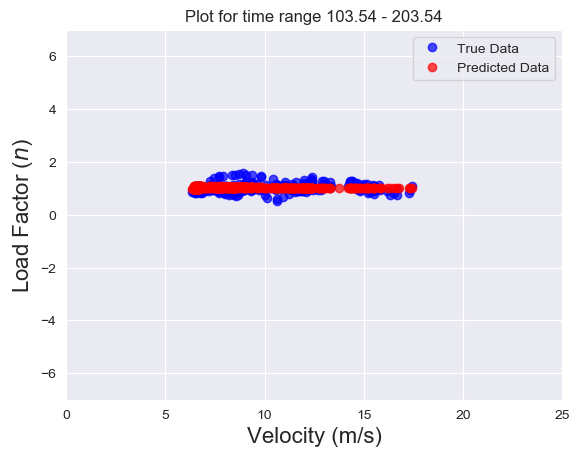

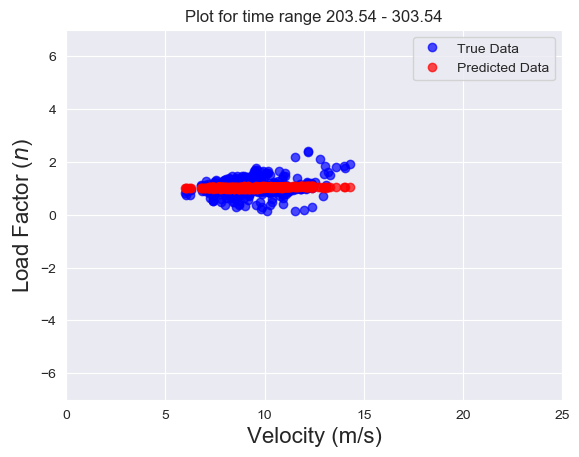

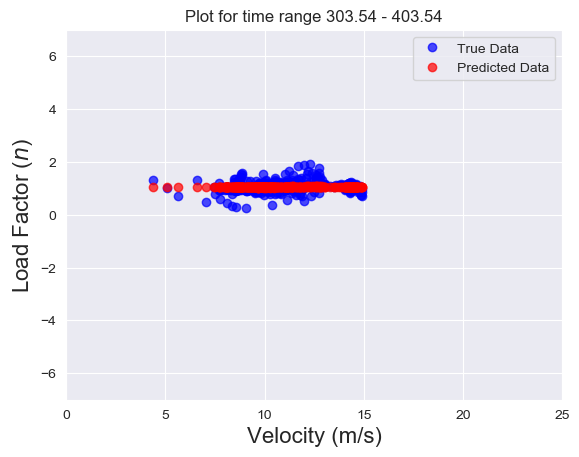

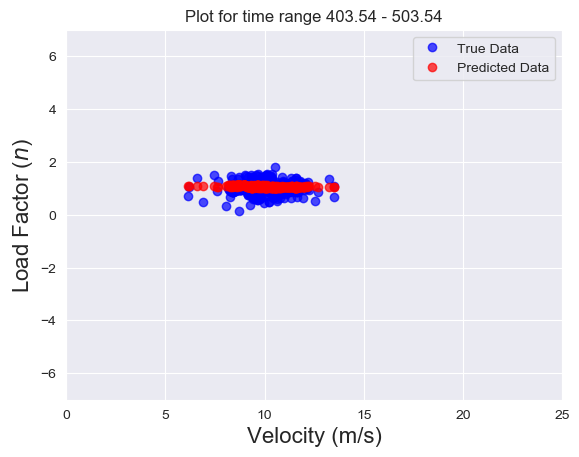

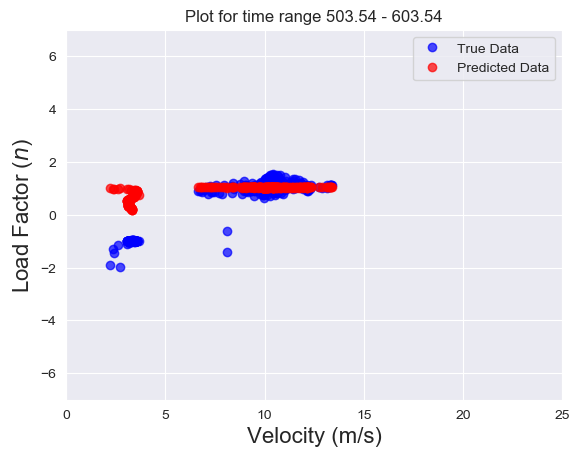

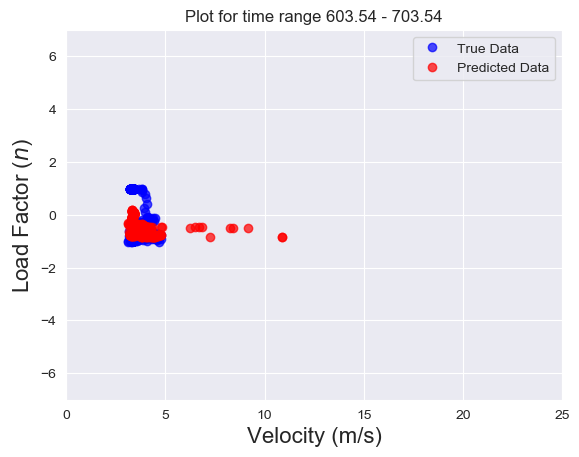

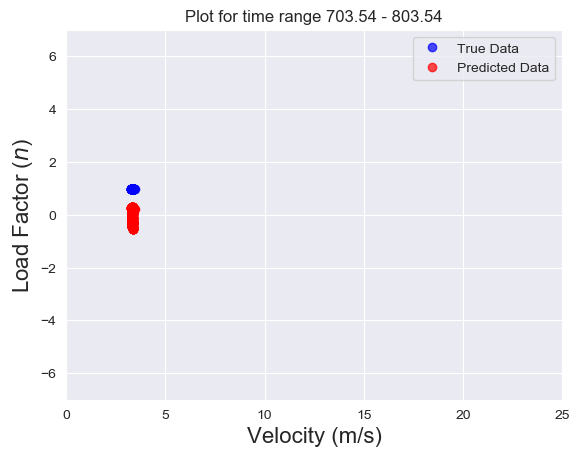

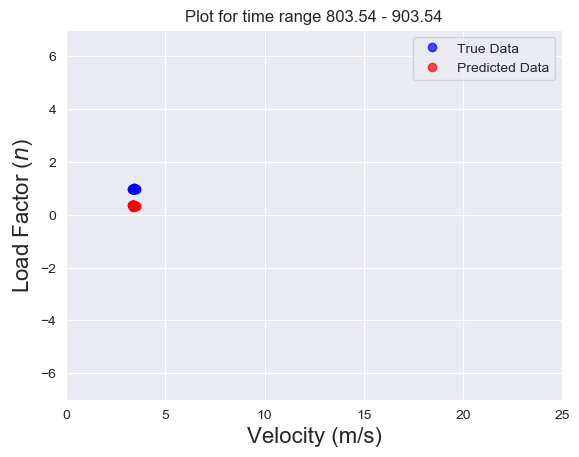

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

filezilla = "/home/taranto/catkin_ws/src/supervisor/flighttest/data/flightTestData.csv"

# Read the data from the file
dataframe = pd.read_csv(filezilla)

# Calculate the total time in seconds
total_time = dataframe["time1"].max() - dataframe["time1"].min()

# Calculate the number of plots to create (one per 100 seconds)
num_plots = int(total_time // 100) + 1

sns.set_style('darkgrid')

# Create plots for every 100 seconds
for i in range(num_plots):
    start_time = dataframe["time1"].min() + i * 100
    end_time = start_time + 100
    plot_data = dataframe[(dataframe["time1"] >= start_time) & (dataframe["time1"] < end_time)]

    # Check if there is any data in the current time range
    if not plot_data.empty:
        fig, ax = plt.subplots()

        # Plot true velocity (x-axis) against true n (y-axis)
        ax.plot(plot_data["true_velocity"], plot_data["true_n"], 'o', color='blue', label='True Data', alpha=0.7)

        # Plot predicted velocity (x-axis) against predicted n (y-axis)
        ax.plot(plot_data["predicted_velocity"], plot_data["predicted_n"], 'o', color='red', label='Predicted Data', alpha=0.7)

        # Customize your plot, e.g., set title, labels, etc.
        ax.set_title(f"Plot for time range {start_time:.2f} - {end_time:.2f}")
        ax.set_xlabel("Velocity (m/s)", fontsize=16)
        ax.set_ylabel("Load Factor ($n$)", fontsize=16)
        ax.legend()
        ax.set_ylim([-7, 7])
        ax.set_xlim(left=0, right=25)

        # Save the plot if needed
        # fig.savefig(f"plot_{i}.png")

        # Show the plot
        plt.show()
